In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave,plot_single_plate
import matplotlib.patches as mpatches
import statsmodels.api as sm
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.io as sio

%matplotlib widget
plt.style.use('presentation.mplstyle')
plates = ['94_20201123']
plate_select = [94]

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]

folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders)


In [3]:
Css = {}
lambss = {}
dss = {}
meancurves = {}
meancurves2 = {}
t0ss = {}
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}

2023-02-09 10:52:36,147-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


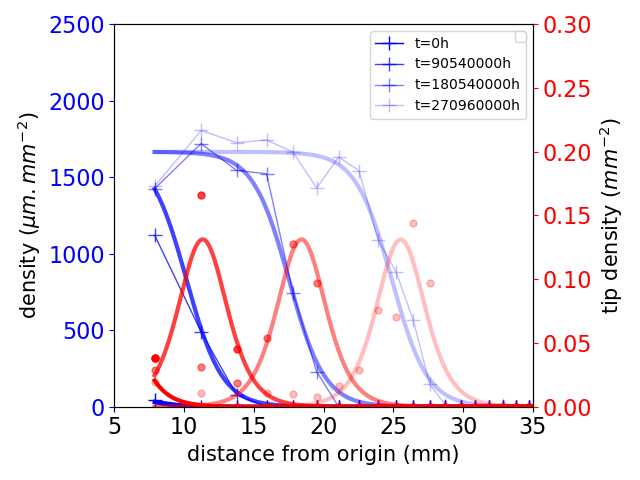

In [7]:
max_indexes = {plate : 20 for plate in plate_select}

plate = 94
timesteps= range(0,timestep[plate]) 

popt_f,r_squared_dens,popt_f2,r_squared_tips =get_wave_fit(time_plate_info,plate,timesteps,max_indexes,lamb = -1,C =1000)
table = time_plate_info.loc[time_plate_info["Plate"]==plate]
table = table.replace(np.nan,-1)
ts = list(table['timestep'])
table = table.set_index('timestep')
ts = list(table.index)
ts.sort()
dic = {}
fig, ax = plt.subplots()
ax.axis([5,35,0,2500])
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('density ($\mu m.mm^{-2}$)') 
ax2=ax.twinx()
ax2.set_ylim((0,0.30))
ax2.set_ylabel('tip density ($mm^{-2}$)')
ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')
timesteps = range(0,timestep[plate],timestep[plate]//4) 
lines = []
for i,t in enumerate(timesteps):
#     ax.set_yscale("log")

    maxL = np.sqrt(1900)
    X = np.linspace(0,maxL,100)
    incr = 100
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t] = {}
    dic[t]['distance_origin'] = xvalues
    dic[t]['ring_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    line = {"type" : "data hypha density","x" : np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    ax.plot(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,
            marker = "+",color="blue",label=f't={table["time_since_begin"][t]}h',
           alpha = (len(timesteps)-i)/len(timesteps),linewidth=1)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    line = {"type" : "fit hypha density","x" : xs,"y" : wave(xt,*popt_f),"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    ax.plot(xs,wave(xt,*popt_f),alpha = (len(timesteps)-i)/len(timesteps),color='blue')
    def density(x):
        area = x**2
        index = int(area//incr)
        column = f"ring_active_tips_density_incr-100_index-{index}"
        return(float(table[column][t]))
    xvalues = np.array([np.sqrt(100*i) for i in range(max_indexes[plate])])
    yvalues = [density(x) for x in xvalues]
    xvalues,yvalues = zip(*[(x,y) for x,y in zip(xvalues,yvalues)])
    dic[t]['tip_density'] = yvalues
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues) 
    X = np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))
    Y = yvalues
    ax2.scatter(np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2)), yvalues,marker = ".",color="red",
           alpha = (len(timesteps)-i)/len(timesteps))
    line = {"type" : "data tip density","x" : (np.sqrt((xvalues**2+table["area_sep_comp"][0])/(np.pi/2))),"y" : yvalues,"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    xs = np.linspace(np.min(X),np.max(X),1000)
    ts = [table['time_since_begin_h'][t] for x in xs]
    xt = np.array((xs,ts))
    ax2.plot(xs,dwave(xt,*popt_f2),alpha = (len(timesteps)-i)/len(timesteps),color='red')
    line = {"type" : "fit tip density","x" : xs,"y" : dwave(xt,*popt_f2),"time_h":table["time_since_begin"][t]/1e6}
    lines.append(line)
    right = 0.90
    top = 0.90
    fontsize = 10
ax.legend()
ax2.legend()
plt.tight_layout()
plt.savefig(f'Figure/Figure1A.svg')

In [10]:
for i,line in enumerate(lines):
    
    sio.savemat(
        f"Figure1\line{i}",
        line
    )

In [18]:
def make_stat(x0,ax):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = 'grey', alpha = 0.01)
        return(a)
    return(statistic)

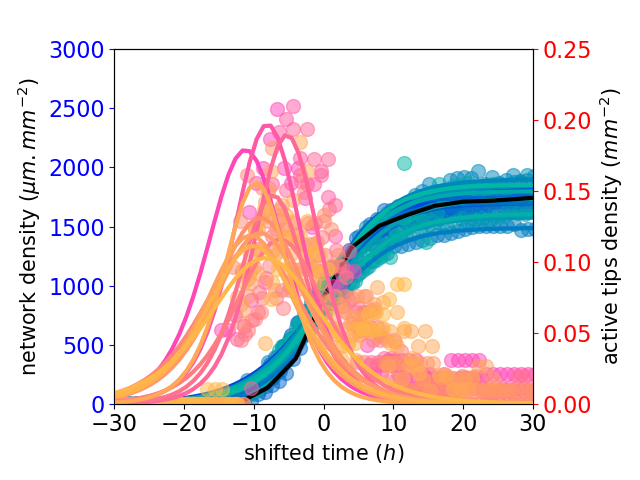

In [20]:
fig,ax = plt.subplots()
maxis = {plate :13 for plate in plate_select}

Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info,timestep[plate],ax,maxi =maxis[plate])
ax.set_title('')
ax.set_ylim(0,3000)
# bbox = dict(facecolor='white', alpha = 0.7,edgecolor="None")

# axins2 = inset_axes(ax, width="30%", height="30%", loc=1,borderpad = .5)
# x0 = np.linspace(np.min(ds),np.max(ds),10)
# statistic = make_stat(x0,axins2)
# data = np.array((ds,Cs))
# n_resamples=1000
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error
# X = sm.add_constant(ds, prepend=False)
# model = sm.OLS(Cs,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# axins2.plot(ds,np.array(ds)*a+b,label = f"{round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
# axins2.scatter(ds,Cs,s=2,label="data")
# axins2.set_ylim(0,2000)
# axins2.set_xlabel('distance from origin (mm)',size = 5,bbox=bbox)
# axins2.set_ylabel('saturation density($\mu m.mm^{-2}$)',size = 5,bbox=bbox)
# axins2.tick_params(labelsize = 5)
# axins2.legend(fontsize = 6)
# axins3 = inset_axes(ax, width="30%", height="30%", loc=4,borderpad = 0.5)
# x0 = np.linspace(np.min(t0s),np.max(t0s),10)
# statistic = make_stat(x0,axins3)
# data = np.array((t0s,ds))
# n_resamples=1000
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error
# axins3.scatter(t0s,ds,label = "data",s=2)
# X = sm.add_constant(t0s, prepend=False)
# model = sm.OLS(ds,X)
# res = model.fit()
# a,b = res.params[0],res.params[1]
# axins3.plot(t0s,np.array(t0s)*a+b,label = f"{int(1000*a)}$\pm$ {int(1000*std)}$\mu m.h^{-1}$",color="black")
# axins3.xaxis.tick_top()
# axins3.xaxis.set_label_position('top') 
# axins3.legend(fontsize = 6 )
# axins3.set_ylabel('distance from center (mm)',size = 5,bbox=bbox)
# axins3.set_xlabel('time of wave crossing (hours)',size = 5,bbox=bbox)
# axins3.tick_params(labelsize = 5)
ax.legend('',frameon = False)
plt.savefig(f'Figure/Figure1B.svg')


2023-02-08 21:43:46,310-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


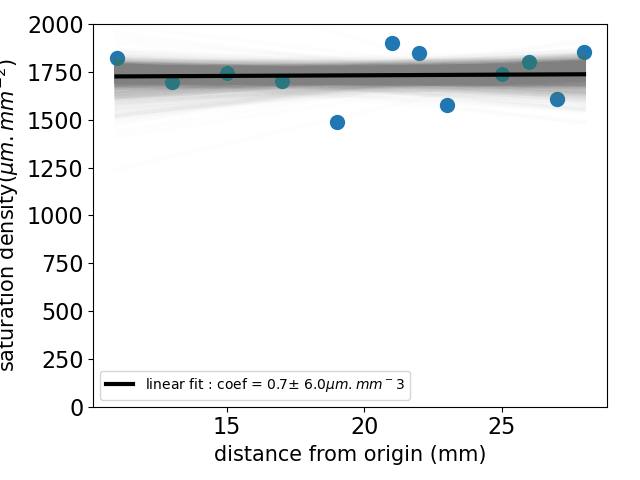

In [21]:
fig, ax = plt.subplots()
ax.legend()
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density($\mu m.mm^{-2}$)')
plt.tight_layout()
x0 = np.linspace(np.min(ds),np.max(ds),10)
def statistic(x,y):
    X = sm.add_constant(x, prepend=False)
    model = sm.OLS(y,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(x0,np.array(x0)*a+b,color = 'grey', alpha = 0.01)
    return(a)
data = np.array((ds,Cs))
n_resamples=1000
std = scipy.stats.bootstrap(data,statistic,
                            vectorized = False,
                            method="basic",
                            n_resamples = n_resamples,
                            paired= True).standard_error
X = sm.add_constant(ds, prepend=False)
model = sm.OLS(Cs,X)
res = model.fit()
a,b = res.params[0],res.params[1]
ax.plot(ds,np.array(ds)*a+b,label = f"linear fit : coef = {round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
plt.legend()
ax.scatter(ds,Cs)
ax.set_ylim(0,2000)

plt.savefig(f'Figure/Figure1Bsubset.svg')


In [9]:
plates = [plate]
analysis_folders = analysis_folders.loc[analysis_folders['Plate'].isin(plates)]
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)

In [13]:
plate = 94
plate_id = '94_20201123'

C:\Users\coren\AppData\Local\Temp\ipykernel_4428\1663699788.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


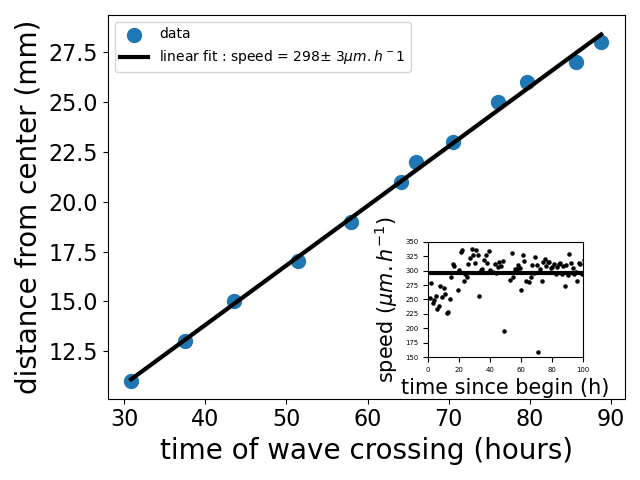

In [36]:
fig, ax = plt.subplots()

def statistic(t0s,ds):
    X = sm.add_constant(t0s, prepend=False)
    model = sm.OLS(ds,X)
    res = model.fit()
    a,b = res.params[0],res.params[1]
    ax.plot(t0s,np.array(t0s)*a+b,color = 'grey', alpha = 0.01)
    
    return(a)
data = np.array((t0s,ds))
n_resamples=10
std = scipy.stats.bootstrap(data,statistic,
                            vectorized = False,
                            method="basic",
                            n_resamples = n_resamples,
                            paired= True).standard_error
ax.scatter(t0s,ds,label = "data")
X = sm.add_constant(t0s, prepend=False)
model = sm.OLS(ds,X)
res = model.fit()
a,b = res.params[0],res.params[1]
ax.plot(t0s,np.array(t0s)*a+b,label = f"linear fit : speed = {int(1000*a)}$\pm$ {int(1000*std)}$\mu m.h^{-1}$",color='black')
ax.legend()
ax.set_ylabel('distance from center (mm)')
ax.set_xlabel('time of wave crossing (hours)')
plt.tight_layout()
plt.savefig(f'Figure/Figure1C.svg')
axins2 = inset_axes(ax, width="30%", height="30%", loc=4, borderpad = 3)
hull_speeds = []
hull_time = []
time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]

data,dy,select_movements = get_average_time_data(plate,time_hypha_info,2)
hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
if len(hyphae_hull)>0:
    label = 'hull pusher'
    for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        select = select.loc[select['speed'].between(150,350)]
        if len(select)>0:
            axins2.scatter(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),color='black',s = 5)
            # axins2.errorbar(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
            label = None
            hull_speeds.append(np.mean(select["speed"]))
            hull_time.append(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1))

        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        # break
        # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
    # ax.plot(data.index/pd.Timedelta(hours = 1),data)
    # axins2.errorbar(data.index/pd.Timedelta(hours = 1),data, yerr=dy,label='average')
    axins2.set_xlim(0,150)
    axins2.set_ylim(150,350)

# axins2.legend()
axins2.set_xlabel('time since begin (h)',size = 15)
axins2.set_ylabel('speed ($\mu m.h^{-1}$)',size = 15)
axins2.tick_params(labelsize = 5)

    # break
axins2.set_xlim(0,100)
plt.tight_layout()
axins2.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
        color="black",
        label= f'mean hull pusher speed {int(np.mean(hull_speeds))}$\pm${int(2*np.std(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
plt.savefig(f'Figure/Figure1Csubset.svg')


In [ ]:
hull_speeds = []
hull_time = []
time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id'].astype(str).str[:len(str(plate))]==str(plate)]

fig,ax = plt.subplots()
data,dy,select_movements = get_average_time_data(plate,time_hypha_info,2)
hyphae_hull = get_hyphae_hull(plate,analysis_folders)
if len(hyphae_hull)>0:
    label = 'hull pusher'
    for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        select = select.loc[select['speed'].between(150,350)]
        if len(select)>0:
            ax.scatter(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),color='black')
            ax.errorbar(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
            label = None
            hull_speeds.append(np.mean(select["speed"]))
            hull_time.append(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1))

        select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
        # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
    # ax.plot(data.index/pd.Timedelta(hours = 1),data)
    ax.errorbar(data.index/pd.Timedelta(hours = 1),data, yerr=dy,label='average')
    ax.set_xlim(0,150)
    ax.set_ylim(150,350)

ax.legend()
# ax.set_title(f'{plate}')
ax.set_xlabel('time since begin (h)')
ax.set_ylabel('speed ($\mu m.h^{-1}$)')
    # break
ax.set_xlim(0,100)
plt.tight_layout()
ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
        color="black",
        label= f'mean hull pusher speed {int(np.mean(hull_speeds))}$\pm${int(2*np.std(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
ax.legend()
# plt.savefig(f'Figure/Figure1Csubset.svg')
